## Amazon Timestream With SageMaker
This is a notebook where we try to estimate the values of the sensors in out Timestream database with the N-BEATS-algorithm implemented by [darts](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html?highlight=nbeats#darts.models.forecasting.nbeats.NBEATSModel) python package

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
import timestreamquery as timestream
from IPython import display
import pandas as pd
import boto3
import botocore
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.models import NBEATSModel, TFTModel
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import holidays_timeseries
# import sagemaker
import sys
import seaborn as sns
import numpy as np
import holidays
import datetime as dt

In [3]:
#################################################
##### Timestream Configurations.  ###############
#################################################
ENDPOINT = "eu-west-1" # <--- specify the region service endpoint
PROFILE = "mose-timestream" # <--- specify the AWS credentials profile
DB_NAME = "SensorData" # <--- specify the database created in Amazon Timestream
TABLE_NAME = "particleTest" # <--- specify the table created in Amazon Timestream
TABLE_NAME_PAST = "yrPast" # <--- specify the table created in Amazon Timestream
TABLE_NAME_PREDICTION = "yrPrediction" # <--- specify the table created in Amazon Timestream


client = timestream.createQueryClient(ENDPOINT, profile=PROFILE)

#################################################
##### SageMaker Configurations. #################
#################################################

eu-west-1


## Logical view of data ##
```sql
DESCRIBE <db_name>.<table_name>
```

In [4]:
query_describe = """
DESCRIBE {}.{}
""".format(DB_NAME, TABLE_NAME)

describe_table = timestream.executeQueryAndReturnAsDataframe(client, query_describe, True)

display.display(describe_table)

QueryId: AEDQCANIB567WMPWJZY2JSCRUUNLJZ7ZGHJ7ZOGSPGDUPNB5I6EAOAJUMRXTCZA
2022-11-03 11:09:04. QueryId: AEDQCANIB567WMPWJZY2JSCRUUNLJZ7ZGHJ7ZOGSPGDUPNB5I6EAOAJUMRXTCZA Time: 2.043. First result: 2.043. Time to read results: 0.0.


,Column,Type,Timestream attribute type
0,tagId,varchar,DIMENSION
1,gateway_id,varchar,DIMENSION
2,measure_name,varchar,MEASURE_NAME
3,time,timestamp,TIMESTAMP
4,temperature,double,MULTI
5,humidity,double,MULTI
6,mc_2_5,bigint,MULTI
7,mc_10_0,bigint,MULTI
8,mc_4_0,bigint,MULTI
9,nc_10_0,bigint,MULTI


In [5]:
sensors = describe_table[describe_table["Timestream attribute type"] == "MULTI"]["Column"]
columns_to_extract = ", ".join([f"ROUND(AVG({sensor_name}), 2) as {sensor_name}_" for sensor_name in sensors])


In [6]:
query_get_all_data = f"""
SELECT BIN(time, 1h) as time_, {columns_to_extract}
FROM {DB_NAME}.{TABLE_NAME}
GROUP BY BIN(time, 1h)
ORDER BY BIN(time, 1h)
"""

df = timestream.executeQueryAndReturnAsDataframe(client, query_get_all_data, True)
display.display(df)

QueryId: AEDQCANIB56UYFILX4D5COASSMIMZGJQQXTS2MRD3EX32OS26NNXGROERR6X6ZI
2022-11-03 11:09:06. QueryId: AEDQCANIB56UYFILX4D5COASSMIMZGJQQXTS2MRD3EX32OS26NNXGROERR6X6ZI Time: 2.029. First result: 2.029. Time to read results: 0.0.


,time_,temperature_,humidity_,mc_2_5_,mc_10_0_,mc_4_0_,nc_10_0_,mc_1_0_,nc_0_5_,nc_2_5_,nc_1_0_,nc_4_0_,typical_particle_size_
0,2022-09-16 14:00:00.000000000,11.90,99.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-16 15:00:00.000000000,11.77,99.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-16 16:00:00.000000000,11.88,99.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-16 17:00:00.000000000,11.83,99.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-16 18:00:00.000000000,11.74,99.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,2022-11-03 06:00:00.000000000,5.97,99.00,1.67,2.25,2.17,10.00,1.33,7.50,9.92,9.50,10.00,748.75
1145,2022-11-03 07:00:00.000000000,7.88,94.67,1.83,2.67,2.42,8.42,1.33,5.67,8.42,7.92,8.42,896.75
1146,2022-11-03 08:00:00.000000000,9.33,86.17,1.58,2.75,2.42,6.08,1.08,2.92,5.83,5.00,6.08,1052.75
1147,2022-11-03 09:00:00.000000000,10.43,83.17,1.67,2.83,2.42,7.00,1.08,4.00,6.92,6.17,7.00,990.00


In [7]:
query_describe_past = """
DESCRIBE {}.{}
""".format(DB_NAME, TABLE_NAME_PAST)

describe_table_past = timestream.executeQueryAndReturnAsDataframe(client, query_describe_past, True)

yr_past_columns = describe_table_past[describe_table_past["Timestream attribute type"] == "MULTI"]["Column"]
columns_to_extract_past = ", ".join([f'ROUND(AVG("{column}"), 2) as "{column}_"' for column in yr_past_columns if column != "max(air_temperature PT1H)"])
query_get_all_data_past = f"""
SELECT BIN(time, 1h) as time_, {columns_to_extract_past}
FROM {DB_NAME}.{TABLE_NAME_PAST}
GROUP BY BIN(time, 1h)
ORDER BY BIN(time, 1h)
"""

df_past = timestream.executeQueryAndReturnAsDataframe(client, query_get_all_data_past, True)
display.display(df_past)

QueryId: AEDQCANIB562AA4YKSBUZJ7XTYTDKOBC2MAJXKOWVYPSYJPAK22TYBGK3UH3CFI
2022-11-03 11:09:06. QueryId: AEDQCANIB562AA4YKSBUZJ7XTYTDKOBC2MAJXKOWVYPSYJPAK22TYBGK3UH3CFI Time: 0.208. First result: 0.208. Time to read results: 0.0.
QueryId: AEDQCANIB56WUCOYJIDPU7DZVFHOLF6VKFHFSA3DSWK4IJKN437BZPVFHA476TI
2022-11-03 11:09:07. QueryId: AEDQCANIB56WUCOYJIDPU7DZVFHOLF6VKFHFSA3DSWK4IJKN437BZPVFHA476TI Time: 0.756. First result: 0.756. Time to read results: 0.0.


,time_,sum(precipitation_amount PT1H)_,max(wind_speed PT1H)_,wind_direction_sin_,wind_direction_cos_
0,2022-08-01 00:00:00.000000000,0.3,3.1,-0.85,-0.53
1,2022-08-01 01:00:00.000000000,0.1,2.6,-0.72,-0.69
2,2022-08-01 02:00:00.000000000,0.5,2.5,-0.72,-0.69
3,2022-08-01 03:00:00.000000000,0.3,2.6,-0.92,-0.39
4,2022-08-01 04:00:00.000000000,0.5,2.5,-0.69,-0.72
...,...,...,...,...,...
2262,2022-11-03 06:00:00.000000000,0.0,1.9,0.17,-0.98
2263,2022-11-03 07:00:00.000000000,0.0,3.2,0.26,-0.97
2264,2022-11-03 08:00:00.000000000,0.0,3.7,-0.22,-0.97
2265,2022-11-03 09:00:00.000000000,0.0,3.4,0.28,-0.96


In [8]:
query_describe_prediction = """
DESCRIBE {}.{}
""".format(DB_NAME, TABLE_NAME_PREDICTION)

describe_table_prediction = timestream.executeQueryAndReturnAsDataframe(client, query_describe_prediction, True)

yr_prediction_columns = describe_table_prediction[describe_table_prediction["Timestream attribute type"] == "MULTI"]["Column"]
columns_to_extract_prediction = ", ".join([f'ROUND(AVG("{column}"), 2) as "{column}_"' for column in yr_prediction_columns])
query_get_all_data_prediction = f"""
SELECT BIN(time, 1h) as time_, {columns_to_extract_prediction}
FROM {DB_NAME}.{TABLE_NAME_PREDICTION}
GROUP BY BIN(time, 1h)
ORDER BY BIN(time, 1h)
"""

df_prediction = timestream.executeQueryAndReturnAsDataframe(client, query_get_all_data_prediction, True)

QueryId: AEDQCANIB56X6C5YJW45KOOXBRUJBPIA3DLBR6ACQUPCDP2VJ27FKYJHHVZ3FOA
2022-11-03 11:09:07. QueryId: AEDQCANIB56X6C5YJW45KOOXBRUJBPIA3DLBR6ACQUPCDP2VJ27FKYJHHVZ3FOA Time: 0.214. First result: 0.214. Time to read results: 0.0.
QueryId: AEDQCANIB56RBOR6NH4MVY7U5P4CVZ5JH4YDB6E4QEGD6G3P4BMMVFHUYI63EWA
2022-11-03 11:09:16. QueryId: AEDQCANIB56RBOR6NH4MVY7U5P4CVZ5JH4YDB6E4QEGD6G3P4BMMVFHUYI63EWA Time: 9.177. First result: 5.326. Time to read results: 3.851.


# Setting up TFTModel with predictions from yr

In [12]:
import os
QUANTILES = [0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99]

In [13]:
df_past.columns

Index(['time_', 'sum(precipitation_amount PT1H)_', 'max(wind_speed PT1H)_',
       'wind_direction_sin_', 'wind_direction_cos_'],
      dtype='object')

In [307]:
df.index = pd.to_datetime(df.time_)
df.index = df.index.tz_localize(None)
series = fill_missing_values(
    TimeSeries.from_dataframe(df, value_cols=[sensor_name + "_" for sensor_name in sensors], fill_missing_dates=True))
df_past.index = pd.to_datetime(df_past.time_)
df_past.index = df_past.index.tz_localize(None)
series_past = fill_missing_values(
    TimeSeries.from_dataframe(df_past, value_cols=[column + "_" for column in yr_past_columns if column != 'max(air_temperature PT1H)'], fill_missing_dates=True))
df_prediction.index = pd.to_datetime(df_prediction.time_)
df_prediction.index = df_prediction.index.tz_localize(None)
df_prediction_renamed = df_prediction.rename(columns={
    '1h_air_temperature_': 'air_temperature_', 
    '1h_percipitation_': 'percipitation_',
    '1h_wind_speed_': 'wind_speed_',
    '1h_wind_direction_cos_': 'wind_direction_cos_',
    '1h_wind_direction_sin_': 'wind_direction_sin_'
})
series_prediction = fill_missing_values(
    TimeSeries.from_dataframe(df_prediction_renamed, value_cols=[
        'air_temperature_', 
        'percipitation_', 
        'wind_speed_',
        'wind_direction_cos_',
        'wind_direction_sin_'
        ], fill_missing_dates=True)
)




In [308]:
last_value = df_prediction.iloc[-24]
columns = list(set([col.split('h_')[1] for col in last_value.index if 'h_' in col ]))
print(columns)
predicted_forecast = pd.DataFrame([[last_value[f'{i}h_{column}'] for column in columns] for i in range(1,25)], columns=columns,
                index=[pd.to_datetime(last_value['time_']) + pd.DateOffset(hours=i) for i in range(24)])
predicted_forecast.index.name = 'time_'
series_prediction_test = fill_missing_values(
    TimeSeries.from_dataframe(predicted_forecast, value_cols=[
        'air_temperature_', 
        'percipitation_', 
        'wind_speed_',
        'wind_direction_cos_',
        'wind_direction_sin_'
        ], fill_missing_dates=True)
)
    
    

['air_temperature_', 'relative_humidity_', 'wind_speed_', 'percipitation_', 'wind_direction_sin_', 'wind_direction_cos_']


In [322]:
from darts.models import Prophet
column_name_test = 'mc_2_5_'

In [350]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

2022-11-03 21:04:34 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-03 21:04:35 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-03 21:04:36 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-03 21:04:37 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-03 21:04:38 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-03 21:04:38 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-03 21:04:39 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-03 21:04:40 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-03 21:04

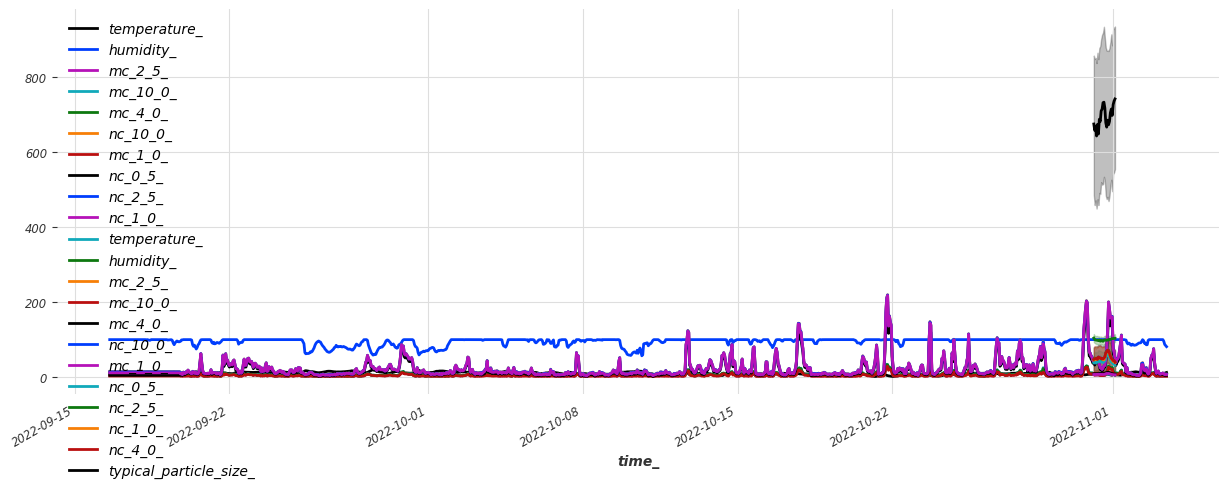

In [352]:
series_train, series_test = series[:-80], series[-24:]
prophet = Prophet()
model_output = []
for sensor_name in sensors:
    sensor_name_ = sensor_name + "_"
    prophet.fit(
        series_train[sensor_name_], 
        future_covariates=series_prediction[:-80],
    )
    prediction_prophet = prophet.predict(n=24, 
                                    future_covariates=series_prediction[:-24].concatenate(series_prediction_test),
                                    num_samples=1000
                                    )
    model_output.append((sensor_name, prediction_prophet))

    

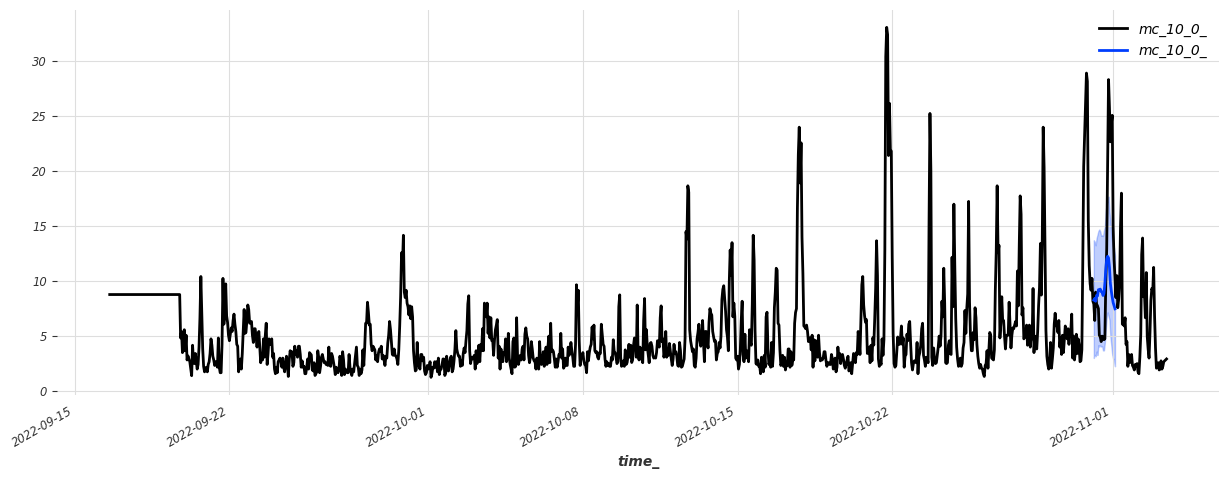

In [373]:
for sensor in model_output[3:]:
    series[f'{sensor[0]}_'].plot()
    sensor[1].plot()
    break

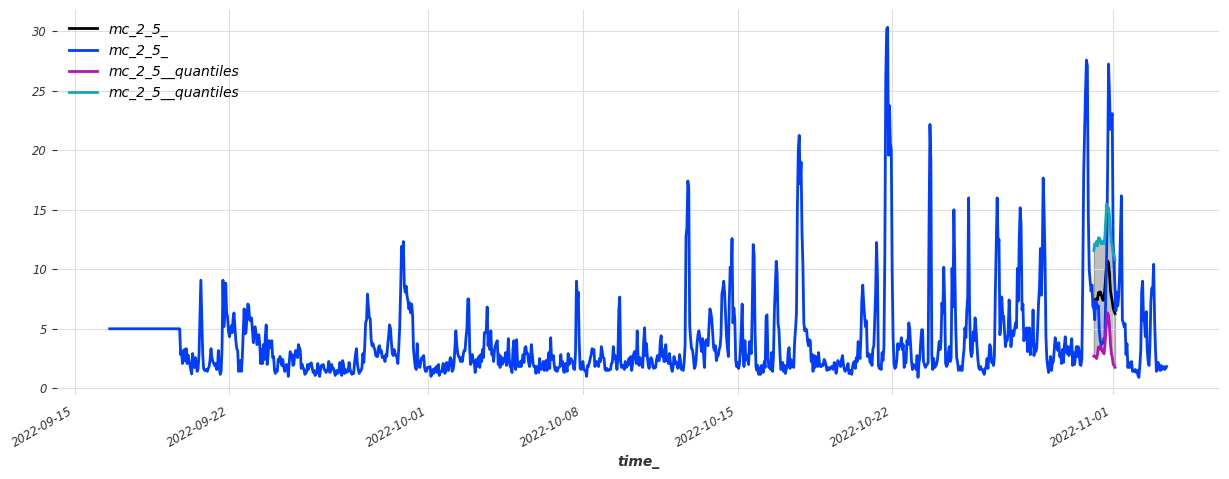

In [348]:
prediction_prophet = prophet.predict(n=24, 
                                    future_covariates=series_prediction[:-24].concatenate(series_prediction_test),
                                    num_samples=1000
                                    )
prediction_prophet.plot()
series[column_name_test].plot()
# series_prediction_test['typical'].plot()
prediction_prophet.quantile(0.05).plot()
prediction_prophet.quantile(0.95).plot()

In [338]:
def eval_model(model, series=series, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=True,
                                          verbose=False, 
                                          forecast_horizon=24)
    
    backtest.plot(label='backtest (n=24)')
    return backtest


In [339]:
back_test = eval_model(
    prophet, 
    series=series['temperature_'], 
    # past_covariates=series_past, 
    future_covariates=series_prediction
)

2022-11-03 20:43:48 cmdstanpy DEBUG: cmd: where.exe tbb.dll
cwd: None
2022-11-03 20:43:48 cmdstanpy DEBUG: TBB already found in load path
2022-11-03 20:43:48 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-11-03 20:43:48 cmdstanpy DEBUG: input tempfile: C:\Users\haako\AppData\Local\Temp\tmpnc0j20q3\vqq0_j9v.json
2022-11-03 20:43:48 cmdstanpy DEBUG: input tempfile: C:\Users\haako\AppData\Local\Temp\tmpnc0j20q3\9jk6drn5.json
2022-11-03 20:43:48 cmdstanpy DEBUG: idx 0
2022-11-03 20:43:48 cmdstanpy DEBUG: running CmdStan, num_threads: None
2022-11-03 20:43:48 cmdstanpy DEBUG: CmdStan args: ['C:\\Users\\haako\\Anaconda3\\envs\\tdt4290\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=48258', 'data', 'file=C:\\Users\\haako\\AppData\\Local\\Temp\\tmpnc0j20q3\\vqq0_j9v.json', 'init=C:\\Users\\haako\\AppData\\Local\\Temp\\tmpnc0j20q3\\9jk6drn5.json', 'output', 'file=C:\\Users\\haako\\AppData\\Local\\Temp\\tm

KeyboardInterrupt: 

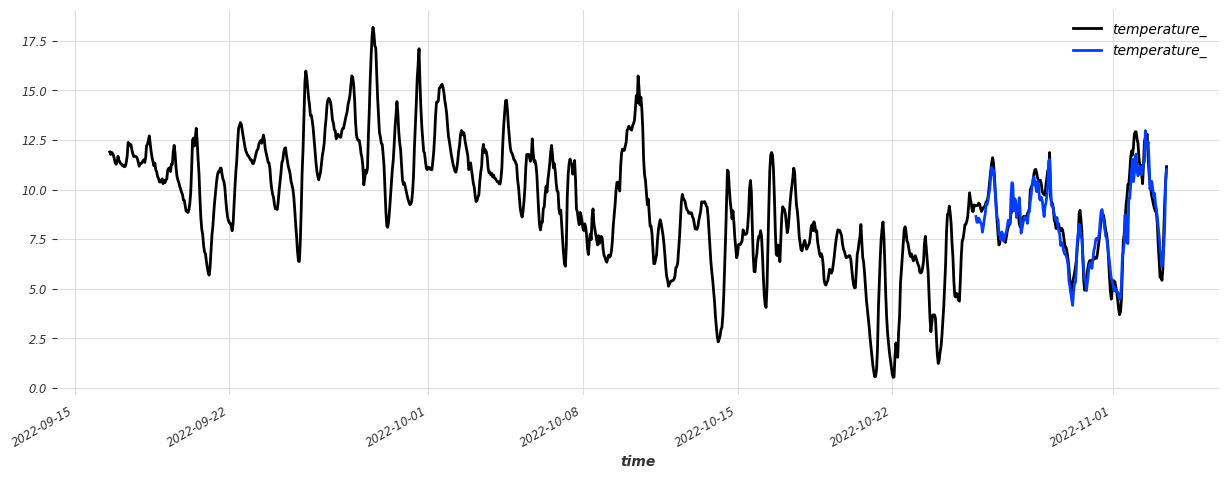

In [58]:
series['temperature_'].plot()
back_test['temperature_'].plot()